In [2]:
import numpy as np
import os, glob, sys

from abc import ABC, abstractmethod

import torch
from torch.utils.data import IterableDataset, DataLoader
from torchvision.utils import save_image

import captum._utils.gradient as captum_grad

sys.path.append('../../../../captum/concept/fb/')
from _utils.common import concepts_to_str

from captum.concept.fb._core.TCAV import TCAV
from captum.concept.fb._core.concept import Concept
from captum.concept.fb._utils.classifier import Classifier

from captum.concept.fb._utils.data_iterator import get_concept_iterator_from_path, CustomIterableDataset

import random
from collections import defaultdict 
from functools import reduce

from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn import metrics

import matplotlib.pyplot as plt
import matplotlib.image as mpimg


from IPython.display import clear_output


# Tutorial

# Testing with Concept Activation Vectors (TCAV)

This tutorial shows how to apply model interpretability using TCAVs.

**Concepts** are high level features such as "striped images" in computer vision image classification tasks or the word "female" in a natural language processing classification task (even if the word female was not part of the dataset).

With that in mind, using concepts as inputs in a pre-trained network, chosen intermediate layer activations are compared to baseline activations (say from random inputs) and, using a **linear classifier**, it is determined a "degree of separation" (the CAVs) between two (or more) concepts. These CAVs are used to compare then by a given metric (TCAV) to an attribution vector (the gradient of the network output wrt the layer output), for a test image.

In this tutorial, we will demonstrate the use of TCAV in a Computer Vision classification task, using a pre-trained model on Imagenet.

**Note:** Before running this tutorial, please install the torchvision, PIL, and matplotlib packages.


<br>

## 1- Get images

First, let's get some images for testing. We are using for this tutorial the images from Imagenet.

In [4]:

import torchvision
from torchvision import transforms

from PIL import Image

# Images - Imagenet
imagenet_data = torchvision.datasets.ImageNet('./imagenet/',  split='val')
SIZE = len(imagenet_data)

# Method to normalize an image to Imagenet mean and standard deviation
def transform(img):

    return transforms.Compose(
        [
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
            ),
        ]
    )(img)


Now let's define a few helper methods:

In [5]:

def get_tensor_from_filename(filename):

    img = Image.open(filename).convert("RGB")
    img = transform(img)

    return img


def get_imagenet_tensors(class_name):
    
    class_ind = imagenet_data.class_to_idx[class_name]
    class_images = [imagenet_data[i][0] for i in range(SIZE) if imagenet_data.targets[i] == class_ind]
    class_tensors = [transform(img) for img in class_images]
    
    return class_tensors, class_ind


def save_image_tensors(tensor_list, root_path, class_name):
    
    for idx, tensor in enumerate(tensor_list):
        path = os.path.join(root_path, class_name)
        save_image(tensor, path + class_name + '_' + '{:04d}'.format(idx) + '.jpg')
        

def load_image_tensors(root_path, class_name):

    path = os.path.join(root_path, class_name)
    filenames = glob.glob(path + '*.jpg')
    
    tensors = []
    for filename in filenames:
        img = Image.open(filename).convert('RGB')
        tensors.append(transform(img))
    
    return tensors


Get sample images from Imagenet:

In [6]:

zebra_tensors, zebra_ind = get_imagenet_tensors('zebra')
tiger_tensors, tiger_ind = get_imagenet_tensors('tiger')
tench_tensors, tench_ind = get_imagenet_tensors('tench')
bassinet_tensors, bassinet_ind = get_imagenet_tensors('bassinet')


Optionally, save and/or load the images:

In [7]:

# Save tensor images

# save_image_tensors(zebra_tensors, './images/', 'zebra')
# save_image_tensors(tiger_tensors, './images/', 'tiger')
# save_image_tensors(tench_tensors, './images/', 'tench')
# save_image_tensors(bassinet_tensors, './images/', 'bassinet')


# Load sample images from folder

# zebra_tensors = load_image_tensors('./images/', 'zebra')
# tiger_tensors = load_image_tensors('./images/', 'tiger')
# tench_tensors = load_image_tensors('./images/', 'tench')
# bassinet_tensors = load_image_tensors('./images/', 'bassinet')


<br>

## 2- Get Model

For this tutorial, we will use the Google LeNet model.

In [8]:
model = torchvision.models.googlenet(pretrained=True)
model = model.eval()

## 3- Custom methods

Now, let's define a few required custom methods that will be used as attribute functions for the TCAV library.

First, a **CustomClassifier** class. It is required to define a class based on the *Classifier* abstract class. We have to define an **init** method (where we are choosing the *sklearn linear_model.SGDClassifier*, a **fit** method for the training, a **predict** method for the its training accuracy metric and a **weights** method, for the actual *interpret* TCAV method, i.e. the actual image test with a particular concept.

In [9]:
#!/usr/bin/env python3

from sklearn import linear_model


class CustomClassifier(Classifier):
    r"""
        Linear Classifier class implementation for the Tests with
        Concept Activation Vectors (TCAVs), as in the paper:
            https://arxiv.org/pdf/1711.11279.pdf

    """

    def __init__(self):

        self.lm = linear_model.SGDClassifier(alpha=0.01, max_iter=1000, tol=1e-3)

    def fit(self, inputs, labels):

        self.lm.fit(inputs.detach().numpy(), labels.detach().numpy())

    def predict(self, inputs):

        #print(torch.tensor(self.lm.predict(inputs.detach().numpy())))
        return torch.tensor(self.lm.predict(inputs.detach().numpy()))

    def weights(self):

        if len(self.lm.coef_) == 1:
            # if there are two concepts, there is only one label. We split it in two.
            return torch.tensor([-1 * self.lm.coef_[0], self.lm.coef_[0]])
        else:
            return torch.tensor(self.lm.coef_)



Next, we have to define a **layer_attributions** method. We also define here a helper method **get_module_from_name** to get the actual layer module whithin the model, from its concatenated hierarchical name:

In [10]:

#def get_module_from_name(model, name):
#    return reduce(getattr, name.split("."), model)


def layer_attributions(model, layer_module, inputs, target, additional_forward_args):

    #attrib = LayerIntergratedGradients().attribute
    attrib, _ , _ = captum_grad.compute_layer_gradients_and_eval(
                               model,
                               layer_module,
                               inputs, target_ind=target)

    return attrib


In addition, we define here another required method, **train_test_split** for splitting the *concepts* data into the train and test sets.

In [11]:

def train_test_split(x_list, y_list, test_split=0.33):

    # Shuffle
    z_list = list(zip(x_list, y_list))
    random.shuffle(z_list)

    # Split
    test_size = int(test_split * len(z_list))
    z_test, z_train = z_list[:test_size], z_list[test_size:]
    x_test, y_test = zip(*z_test)
    x_train, y_train = zip(*z_train)

    x_train = torch.stack(x_train)
    x_test = torch.stack(x_test)
    y_train = torch.stack(y_train)
    y_test = torch.stack(y_test)

    return x_train, x_test, y_train, y_test


<br>

## 4- Define Concepts

We define now 2 helper methods for assembling concepts from folders and also generating random concepts.

First, the simple **assemble_concepts** method reads the concepts from a list and, assuming these concept files are located in a folder with the same name, reads these files and creates a list of *Concept* objects.

In [12]:

def assemble_concepts(concept_list, concepts_path="./concepts/"):
    
    concepts = []
    
    for concept_name in concept_list:

        concept_path = os.path.join(concepts_path, concept_name) + "/"
        dataset = CustomIterableDataset(get_tensor_from_filename, concept_path)
        concept_iter = get_concept_iterator_from_path(dataset)
        concepts.append(Concept(id=len(concepts), name=concept_name, data_iter=concept_iter))
    
    return concepts


Second, we create a method **gen_random_concepts** for generating random concepts. We create random concepts here using random images from Imagenet. These random concepts will be saved on a folder with the same name as its concept name.

In [13]:

def gen_random_concepts(imagenet_data, concept_name, concepts_path="./concepts/", size=50):
    
    concept_path = os.path.join(concepts_path, concept_name) + "/"
    
    if not os.path.exists(concept_path):
        os.mkdir(concept_path)
    else:
        files = glob.glob(concept_path + '*')
        for f in files:
            if os.path.isfile(f):
                os.remove(f)
    
    # Random Tensors
    random_images = [imagenet_data[np.random.randint(len(imagenet_data))][0] for i in range(size)]
    random_tensors = [transform(img) for img in random_images]
    
    for idx, random_tensor in enumerate(random_tensors):
        save_path = os.path.join(concept_path, 'random_' + '{:04d}'.format(idx) + '.jpg')
        save_image(random_tensor, save_path)


Now we are ready to run a vanilla example!

<br>

## 5- Basic Run

Let's go step by step about the basics for the TCAV.

First, let's generate some random concepts:

In [14]:
gen_random_concepts(imagenet_data, "random1", size=50)
gen_random_concepts(imagenet_data, "random2", size=50)

Then we read and assemble the concepts from files into the Concepts class:

In [15]:

concept_list = ["striped", "random1", "random2"]
concepts_path="./concepts/"

concepts = assemble_concepts(concept_list, concepts_path)


Let's show some concepts samples:

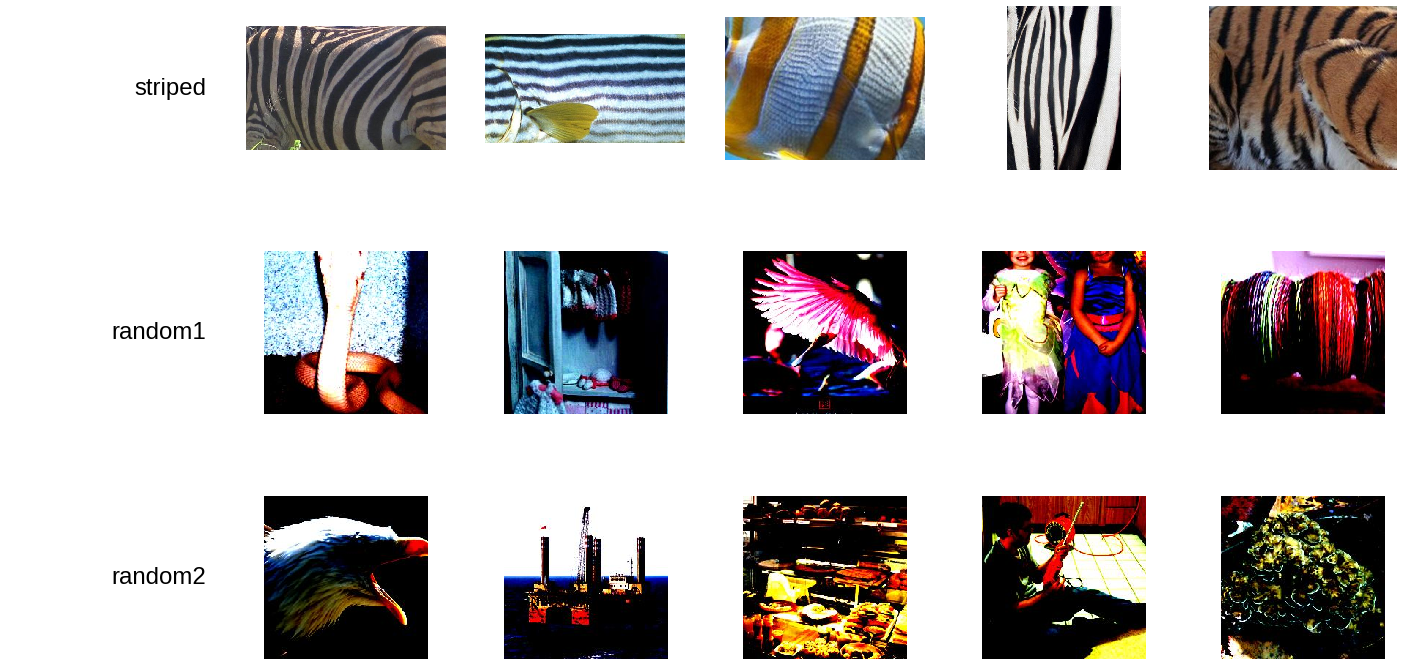

In [16]:

n_figs = 5
n_concepts = len(concept_list)

fig, axs = plt.subplots(n_concepts, n_figs + 1, figsize = (25, 4 * n_concepts))

for c, concept_name in enumerate(concept_list):
    
    #plt.figtext(0.1, (n_concepts - c) / n_concepts, concept_name, ha="left", va="top", fontsize=21)
    
    concept_path = os.path.join(concepts_path, concept_name) + "/"
    img_files = glob.glob(concept_path + '*')
    
    for i, img_file in enumerate(img_files[:n_figs + 1]):
        if os.path.isfile(img_file):
            
            if i == 0:
                axs[c, i].text(1.0, 0.5, str(concept_name), ha='right', va='center', family='sans-serif', size=24)
            else:
                img = mpimg.imread(img_file)
                axs[c, i].imshow(img)

            axs[c, i].axis('off')


<br>

Then, lets create 2 experimental sets: **\["striped", "random2"\]** and **\["striped", "random2"\]**. They have to be assembled into Concept objects, though:

In [17]:

experimental_set_list = [["striped", "random1"], ["ceo", "random2"]]
experimental_set = []

for concepts_list in experimental_set_list:
    experimental_set.append(assemble_concepts(concepts_list))
    

<br>

Next, let's create the TCAV class, with the required attributes:

In [18]:

mytcav = TCAV(model=model, 
              concepts=concepts,
              layers=['inception4c', 'inception4d', 'inception4e'],
              classifier=CustomClassifier(),
              layer_attribution_func=layer_attributions,
              train_test_split_func=train_test_split)
              

<br>

Finally, lets actually "TCAV", i.e. Test with the computed CAVs. We will use the zebra images to try it out:

In [19]:

scores = mytcav.interpret(inputs=torch.stack(zebra_tensors),
                          experimental_set=experimental_set,
                          target=zebra_ind)
scores


defaultdict(<function TCAV.TCAV.interpret.<locals>.<lambda>()>,
            {'striped-random1': defaultdict(None,
                         {'inception4c': {'sign_count': tensor([0.6800, 0.3200]),
                           'magnitude': tensor([0.6591, 0.3409])},
                          'inception4d': {'sign_count': tensor([0.8200, 0.1800]),
                           'magnitude': tensor([0.9412, 0.0588])},
                          'inception4e': {'sign_count': tensor([0.1000, 0.9000]),
                           'magnitude': tensor([0.0348, 0.9652])}}),
             'ceo-random2': defaultdict(None,
                         {'inception4c': {'sign_count': tensor([0.4200, 0.5800]),
                           'magnitude': tensor([0.4342, 0.5658])},
                          'inception4d': {'sign_count': tensor([0.5200, 0.4800]),
                           'magnitude': tensor([0.6074, 0.3926])},
                          'inception4e': {'sign_count': tensor([0.4800, 0.5200]),
           

We can then present the results with a chart:

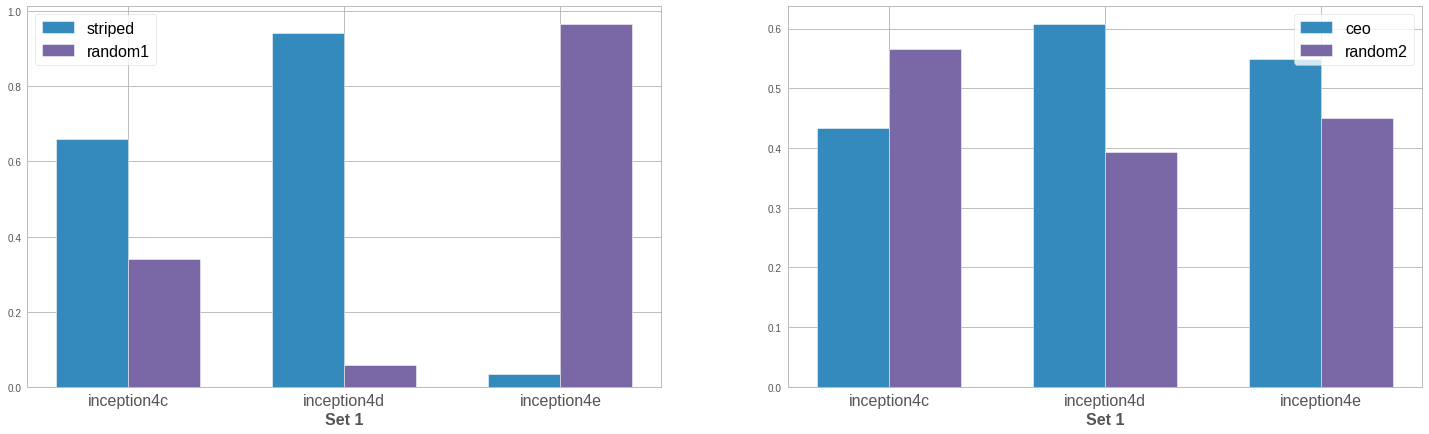

In [20]:
def format_float(f):
    
    if abs(f) >= 0.0005:
        return '{:.3f}'.format(f)
    else:
        return '{:.3e}'.format(f)

    
layers=['inception4c', 'inception4d', 'inception4e']

n_rows = 1
n_figs = len(experimental_set_list)

fig, ax = plt.subplots(n_rows, n_figs, figsize = (25, 7 * n_rows))
fs = 16

barWidth = 1 / (len(experimental_set_list[0]) + 1)
bars = np.zeros((len(experimental_set_list[0]), len(layers)))

for idx_es, concepts in enumerate(experimental_set):

    concepts = experimental_set[idx_es]
    concepts_key = concepts_to_str(concepts)
    for c, concept in enumerate(concepts):
        for l, layer in enumerate(layers):
            bars[c, l] = format_float(scores[concepts_key][layer]['magnitude'][c])

    pos = []
    pos.append(np.arange(len(layers)))
    #pos.append([0.25, 1.25])
    #print(pos)
    for i in range(len(experimental_set_list[0]))[1:]:
        pos.append([(x + barWidth) for x in pos[i-1]])
        #print(pos)

    for i in range(len(experimental_set_list[0])):
        ax[idx_es].bar(pos[i], bars[i], width=barWidth, edgecolor='white', label=experimental_set_list[idx_es][i])

    # Add xticks on the middle of the group bars
    ax[idx_es].set_xlabel('Set 1', fontweight='bold', fontsize=fs)
    ax[idx_es].set_xticks([r + 0.5 * barWidth for r in range(len(bars[0]))])
    ax[idx_es].set_xticklabels(layers, fontsize=fs)

    # Create legend & Show graphic
    ax[idx_es].legend(fontsize=fs)

plt.show()


## 5- Advanced Run - Stats

For this part, let's run many experiments. Dozens of them. And then graph statistics on the results.

First, we define a function to extract a population of results from a dictionary of Scores into a list.

In [21]:

def assemble_scores(scores, experimental_sets, idx, score_layer, score_type):
    
    score_list = []
    for concepts in experimental_sets:
        score_list.append(scores["-".join([c for c in concepts])][score_layer][score_type][idx])
        
    return score_list
    

Now, let's define a convenience function for assembling the experiments together as lists of Concept objects, creating and running the TCAV:

In [22]:

def get_scores(model, layers, concept_list, experimental_set_list, inputs, target,
               lm, layer_attributions, train_test_split, concepts_path="./concepts/"):

    # Invoke the function to convert a list of Concept names into a list of Concept objects.
    concepts = assemble_concepts(concept_list, concepts_path)
    
    # Convert all experiment sets (concept name tuples) into a list of concept objects tuple.
    experimental_set = []
    for concepts_list in experimental_set_list:
        experimental_set.append(assemble_concepts(concepts_list))

    # Create a TCAV object
    mytcav = TCAV(model, concepts, layers, lm, layer_attributions, train_test_split)

    # Obtain a dictionary of scores for the desired inputs (test images)
    scores = mytcav.interpret(inputs, experimental_set, target)
        
    return scores


In addition, it is interesting to evaluate the p-values between the concept population pairs. We want to evaluate if these pupulations are overlapping (if both are random, for example) or if they are disjoint (if they are meant to be different, such as striped and random):

In [23]:

from scipy.stats import ttest_1samp, ttest_ind

def format_float(f):
    
    if abs(f) >= 0.0005 or abs(f) == 0.0:
        return '{:.3f}'.format(f)
    else:
        return '{:.3e}'.format(f)

def get_pval(scores, experimental_sets, score_layer, score_type, alpha=0.05, print_ret=False):
    
    P1 = assemble_scores(scores, experimental_sets, 0, score_layer, score_type)
    P2 = assemble_scores(scores, experimental_sets, 1, score_layer, score_type)
    
    if print_ret:
        print('P1[mean, std]: ', format_float(np.mean(P1)), format_float(np.std(P1)))
        print('P2[mean, std]: ', format_float(np.mean(P2)), format_float(np.std(P2)))

    tset, pval = ttest_ind(P1, P2)

    if print_ret:
        print("p-values:", format_float(pval))

    if pval < alpha:    # alpha value is 0.05 or 5%
        relation = "Disjoint"
        if print_ret:
            print("Disjoint")
    else:
        relation = "Overlap"
        if print_ret:
            print("Overlap")
        
    return P1, P2, format_float(pval), relation


Finally, let's assemble 3 important lists, containing the desired layers, concepts and the experiment concept pairs. In the end, we want to have defined:

layer_list = **['inception4c']**

concept_list = **['striped', 'ceo', 'random_0', 'random_1', 'random2', ... , 'random_n']**, n = n_exp (number of experiments)

experimental_set = **[['striped', 'random_1'], ['striped', 'random_2'], ... , ['striped', 'random_n'],  
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&nbsp;['random_0', 'random_1'], ['random_0', 'random_2'], ... ,['random_0', 'random_n']]**

In [24]:
layer_list = ['inception4c', 'inception4d']
concept_list = ['striped', 'ceo']
experimental_set_list = []

concept_list_all = list(concept_list)

n_exp = 5

for i in range(n_exp + 1):
    gen_random_concepts(imagenet_data, 'random_' + str(i), size=50)
    concept_list_all.append('random_' + str(i))

for c in concept_list:
    for i in range(1, n_exp + 1):
        experimental_set_list.append([c, 'random_' + str(i)])
    
for i in range(1, n_exp + 1):
    experimental_set_list.append(['random_0', 'random_' + str(i)])


We now run the TCAV and obtain the scores:

In [25]:
import time
start = time.time()

# Run TCAV
scores = get_scores(model, layer_list, concept_list_all, experimental_set_list,
                    torch.stack(zebra_tensors), zebra_ind, CustomClassifier(), layer_attributions, 
                    train_test_split)

scores

print(time.time() - start)

76.42263865470886


In [26]:
# Parallel:      82s (-34%)
# Non-parallel: 125s (+52%)

We can present the results boxplot and the p-values indicating the overlapping/disjoint probabilities over each concept score population with respect to its score population pair:

In [27]:
def show_boxplots(layer, metric):

    def format_label_text(concept_name_list):

        formated_list = list(concept_name_list)

        for i, c in enumerate(concept_name_list):
            if c.startswith('random'):
                formated_list[i] = 'random'

        return formated_list


    n_plots = len(concept_list) + 1

    fig, ax = plt.subplots(1, 3, figsize = (25, 7 * 1))
    fs = 18

    for n in range(n_plots):

        esl = experimental_set_list[n * n_exp : (n+1) * n_exp]
        P1, P2, pval, relation = get_pval(scores, esl, layer, metric)

        ax[n].set_ylim([0, 1])
        ax[n].set_title(layer + "-" + metric + " (pval=" + str(pval) + " - " + relation + ")", fontsize=fs)
        ax[n].boxplot([P1, P2], showfliers=True)

        ax[n].set_xticklabels(format_label_text(esl[0]), fontsize=fs)

    plt.show()

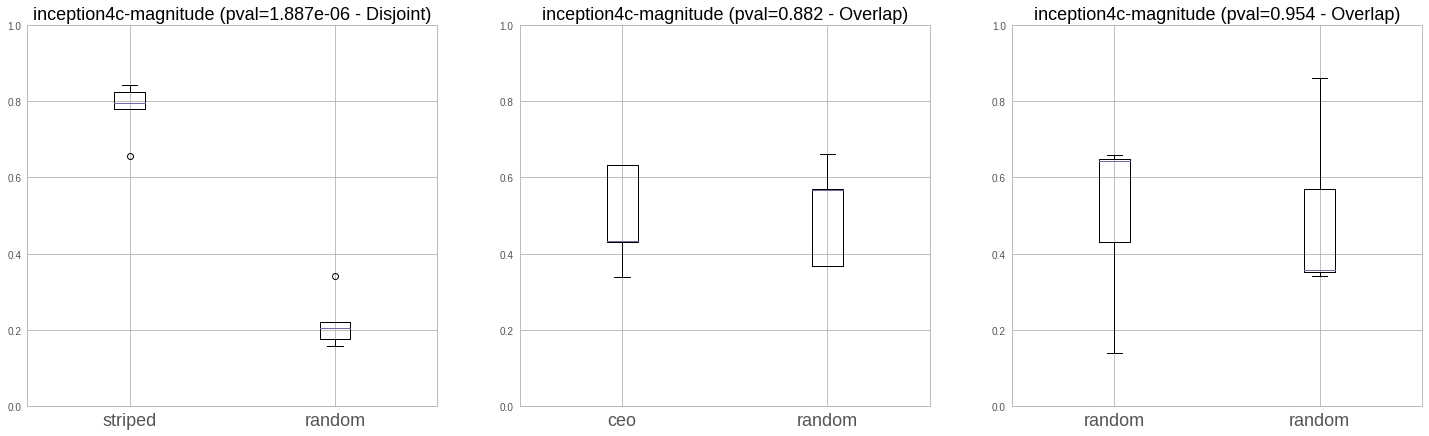

In [28]:
show_boxplots ("inception4c", "magnitude")

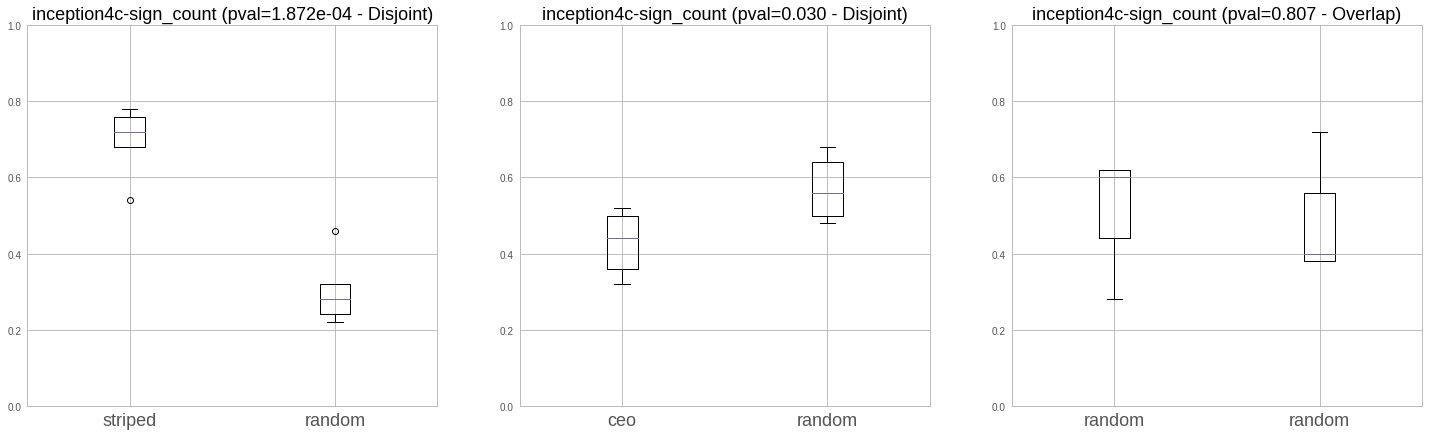

In [29]:
show_boxplots ("inception4c", "sign_count")

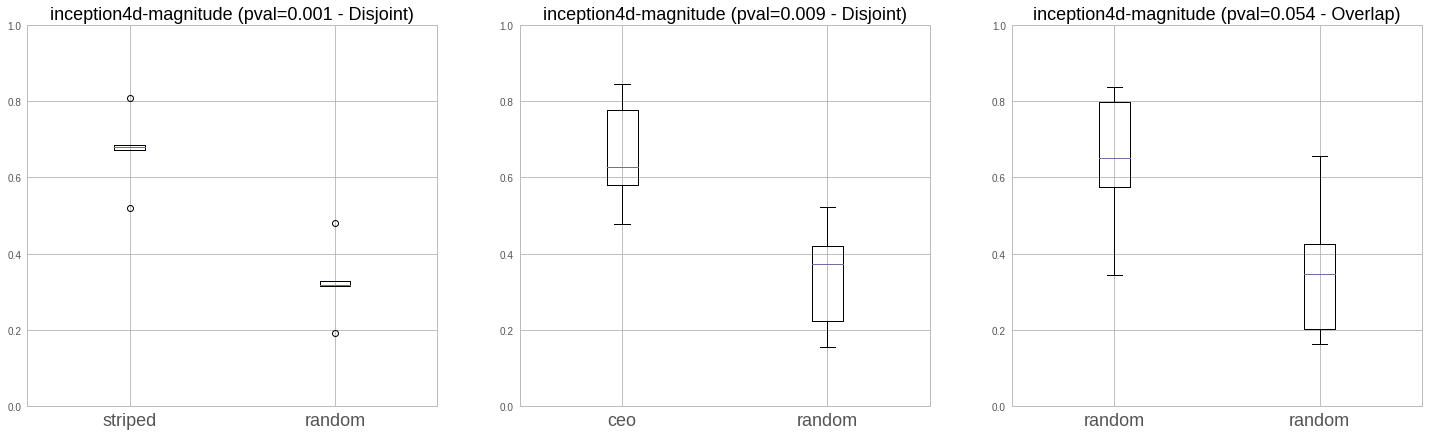

In [30]:
show_boxplots ("inception4d", "magnitude")

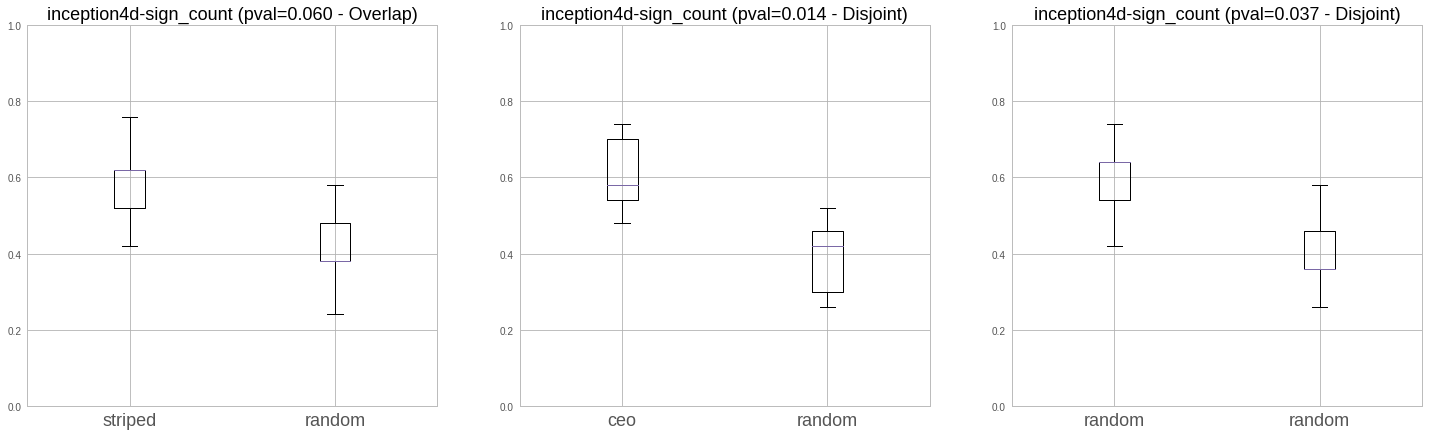

In [31]:
show_boxplots ("inception4d", "sign_count")

### Show Scores

In [32]:
# Get scores from every n_iter
for layer in layer_list:
    print("Layer:", layer)
    for i in range(len(concept_list) + 1):
        print("Set:", experimental_set_list[i * n_exp : (i+1) * n_exp])
        print()
        for metric in ["sign_count", "magnitude"]:
            print("Metric:", metric)
            get_pval(scores, experimental_set_list[i * n_exp : (i+1) * n_exp], layer, metric, print_ret=True)
            print()

Layer: inception4c
Set: [['striped', 'random_1'], ['striped', 'random_2'], ['striped', 'random_3'], ['striped', 'random_4'], ['striped', 'random_5']]

Metric: sign_count
P1[mean, std]:  0.696 0.085
P2[mean, std]:  0.304 0.085
p-values: 1.872e-04
Disjoint

Metric: magnitude
P1[mean, std]:  0.780 0.065
P2[mean, std]:  0.220 0.065
p-values: 1.887e-06
Disjoint

Set: [['ceo', 'random_1'], ['ceo', 'random_2'], ['ceo', 'random_3'], ['ceo', 'random_4'], ['ceo', 'random_5']]

Metric: sign_count
P1[mean, std]:  0.428 0.078
P2[mean, std]:  0.572 0.078
p-values: 0.030
Disjoint

Metric: magnitude
P1[mean, std]:  0.494 0.119
P2[mean, std]:  0.506 0.119
p-values: 0.882
Overlap

Set: [['random_0', 'random_1'], ['random_0', 'random_2'], ['random_0', 'random_3'], ['random_0', 'random_4'], ['random_0', 'random_5']]

Metric: sign_count
P1[mean, std]:  0.512 0.134
P2[mean, std]:  0.488 0.134
p-values: 0.807
Overlap

Metric: magnitude
P1[mean, std]:  0.504 0.201
P2[mean, std]:  0.496 0.201
p-values: 0.954
O